In [1]:
#LogP/SA calculator

In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
import random
from rdkit.Chem import rdFreeSASA
from pymongo import MongoClient
import pandas as pd
#from rdkit.Chem.Draw import IPythonConsole

In [3]:
#monomers for polyamides

# AMINO ACIDS
# format: name shortname SMILES protonated_SMILES
#{'name': 'Alanine', 'shortname': 'ala', 'smiles':'C[C@@H](C(=O)O)N', 'smiles_prot': 'C[C@@H](C(=O)[O-])[NH3+]'}
# (NAME, SHORT_NAME, SMILES, protonated SMILES)

aminoacid_fancy_dict = [
    ("Alanine", "ala", "C[C@@H](C(=O)O)N", "C[C@@H](C(=O)[O-])[NH3+]"),
    ("Beta-Alanine", "beta-ala", "NCCC(O)=O", "[NH3+]CCC([O-])=O"),
    ("L-cysteine", "L-cysteine", "C([C@@H](C(=O)O)N)S", "C([C@@H](C(=O)[O-])[NH3+])S"),
    ("L-DOPA", "L-DOPA", "N[C@H](C(O)=O)CC1=CC=C(O)C(O)=C1", "[NH3+][C@H](C([O-])=O)CC1=CC=C(O)C(O)=C1"),
    ("Glycine", "glycine", "C(C(=O)O)N", "C(C(=O)[O-])[NH3+]"),
    ("L-isoleucine", "L-isoleucine", "N[C@@H](C(C)CC)C(O)=O", "[NH3+][C@@H](C(C)CC)C([O-])=O"),
    ("L-leucine", "L-leucine", "N[C@@H](CC(C)C)C(O)=O", "[NH3+][C@@H](CC(C)C)C([O-])=O"),
    ("L-phenylalanine", "L-phenylala", "N[C@@H](CC1=CC=CC=C1)C(O)=O", "[NH3+][C@@H](CC1=CC=CC=C1)C([O-])=O"),
    ("L-penylalanine_F", "L-phenylala_F", "N[C@@H](CC1=CC=C(F)C=C1)C(O)=O", "[NH3+][C@@H](CC1=CC=C(F)C=C1)C([O-])=O"),
    ("L-phenylalanine_Cl", "L-phenylala_Cl", "N[C@@H](CC1=CC=C(Cl)C=C1)C(O)=O", "[NH3+][C@@H](CC1=CC=C(Cl)C=C1)C([O-])=O"),
    ("L-phenylalanine_N", "L-phenylala_N", "N[C@@H](CC1=CC=C(N)C=C1)C(O)=O", "[NH3+][C@@H](CC1=CC=C(N)C=C1)C([O-])=O"),
    ("L-phenylalanine_CN", "L-phenylala_CN", "N[C@@H](CC1=CC=C(C#N)C=C1)C(O)=O", "[NH3+][C@@H](CC1=CC=C(C#N)C=C1)C([O-])=O"),
    ("L-phenylglycine", "L-phenylgly", "N[C@@H](C1=CC=CC=C1)C(O)=O", "[NH3+][C@@H](C1=CC=CC=C1)C([O-])=O"),
    ("L-proline", "L-proline", "C1C[C@H](NC1)C(=O)O", "[O-]C(=O)[C@H](CCC2)[NH2+]2"),
    ("L-threonine", "L-threonine", "C[C@H]([C@@H](C(=O)O)N)O", "C[C@H]([C@@H](C(=O)[O-])[NH3+])O"),
    ("L-valine", "L-valine", "CC(C)[C@@H](C(=O)O)N", "CC(C)[C@@H](C(=O)[O-])[NH3+]"),
    ("(S)-2-amino-3-phenylpropan-1-ol", "(S)-2-amino-3-phenylpropan-1-ol", "N[C@H](CO)CC1=CC=CC=C1", "[NH3+][C@H](CO)CC1=CC=CC=C1"),
    ("(S)-3-amino-4-phenylbutanoic-acid", "(S)-3-amino-4-phenylbutanoic-acid", "OC(C[C@@H](N)CC1=CC=CC=C1)=O", "OC(C[C@@H]([NH3+])CC1=CC=CC=C1)=O"),
    ("52%-one", "", "OC([C@@H](NC(C)=O)CC1=CC=CC=C1)=O", "OC([C@@H]([NH2+]C(C)=O)CC1=CC=CC=C1)=O"),
]

aminoacid_dict={'ala': 'C[C@@H](C(=O)O)N',
                'ala-prot': 'C[C@@H](C(=O)[O-])[NH3+]',
                'beta-ala': 'NCCC(O)=O',
                'beta-ala-prot': '[NH3+]CCC([O-])=O',
                'L-cystiene': 'C([C@@H](C(=O)O)N)S',
                'L-cystiene-prot': 'C([C@@H](C(=O)[O-])[NH3+])S',
                'L-DOPA': 'N[C@H](C(O)=O)CC1=CC=C(O)C(O)=C1',
                'L-DOPA-prot': '[NH3+][C@H](C([O-])=O)CC1=CC=C(O)C(O)=C1',
                'glycine': 'C(C(=O)O)N',
                'glycine-prot': 'C(C(=O)[O-])[NH3+]',
                'L-isoleucine': 'N[C@@H](C(C)CC)C(O)=O',
                'L-isoleucine-prot': '[NH3+][C@@H](C(C)CC)C([O-])=O',
                'L-leucine': 'N[C@@H](CC(C)C)C(O)=O',
                'L-leucine-prot': '[NH3+][C@@H](CC(C)C)C([O-])=O',
                'L-phenylala': 'N[C@@H](CC1=CC=CC=C1)C(O)=O',
                'L-phenylala-prot': '[NH3+][C@@H](CC1=CC=CC=C1)C([O-])=O',
                'L-phenylala_F': 'N[C@@H](CC1=CC=C(F)C=C1)C(O)=O',
                'L-phenylala_F-prot': '[NH3+][C@@H](CC1=CC=C(F)C=C1)C([O-])=O', # fixed F for CL
                'L-phenylala_Cl': 'N[C@@H](CC1=CC=C(Cl)C=C1)C(O)=O',
                'L-phenylala_Cl-prot': '[NH3+][C@@H](CC1=CC=C(Cl)C=C1)C([O-])=O',
                'L-phenylala_N': 'N[C@@H](CC1=CC=C(N)C=C1)C(O)=O',
                'L-phenylala_N-prot': '[NH3+][C@@H](CC1=CC=C(N)C=C1)C([O-])=O',
                'L-phenylala_CN': 'N[C@@H](CC1=CC=C(C#N)C=C1)C(O)=O',
                'L-phenylala_CN-prot': '[NH3+][C@@H](CC1=CC=C(C#N)C=C1)C([O-])=O',
                'L-phenylgly': 'N[C@@H](C1=CC=CC=C1)C(O)=O',
                'L-phenylgly-prot': '[NH3+][C@@H](C1=CC=CC=C1)C([O-])=O',
                'L-proline': 'C1C[C@H](NC1)C(=O)O',
                'L-proline-prot': '[O-]C(=O)[C@H](CCC2)[NH2+]2',
                'L-threonine': 'C[C@H]([C@@H](C(=O)O)N)O',
                'L-threonine-prot': 'C[C@H]([C@@H](C(=O)[O-])[NH3+])O',
                'L-valine': 'CC(C)[C@@H](C(=O)O)N',
                'L-valine-prot': 'CC(C)[C@@H](C(=O)[O-])[NH3+]',
                '(S)-2-amino-3-phenylpropan-1-ol': 'N[C@H](CO)CC1=CC=CC=C1',
                '(S)-2-amino-3-phenylpropan-1-ol-prot': '[NH3+][C@H](CO)CC1=CC=CC=C1',
                '(S)-3-amino-4-phenylbutanoic-acid': 'OC(C[C@@H](N)CC1=CC=CC=C1)=O',
                '(S)-3-amino-4-phenylbutanoic-acid-prot': 'OC(C[C@@H]([NH3+])CC1=CC=CC=C1)=O', # CHECK PROTONATION
                '52%': 'OC([C@@H](NC(C)=O)CC1=CC=CC=C1)=O', # (S)-2-<something>-3-propanoic acid
                '52%-prot': 'OC([C@@H]([NH2+]C(C)=O)CC1=CC=CC=C1)=O'
                }

amide_dict={'Nylon6': 'CCCCCC(=O)N'
}

#monomers and comonomers for polycarbonates
carbonate_dict={'BPA_Carbonate':  'c1ccc(cc1)C(C)(C)c1ccc(cc1)OC(=O)O'
}

#monomers and comonomers for polyamides
amide_dict={'Ethylene_Terephthalamide': 'CCNC(=O)c1ccc(cc1)C(=O)N',
}

#monomers and comonomers for polyesters
ester_dict={'Butylene_Adip': 'C(=O)CCCCC(=O)OCCCCO',
          'Butylene_Succinate': 'C(=O)CCC(=O)OCCCCO', 
          'Butylene_Terephthalate': 'CCCCOC(=O)c1ccc(cc1)C(=O)O',
          'Ethylene_Terephthalate': 'CCOC(=O)c1ccc(cc1)C(=O)O', 
          '3HBV': 'C(CC)CC(=O)O', 
          '3HB': 'C(C)CC(=O)O',
          'Lactic_acid': 'C(C)C(=O)O',
}

#monomers for polyethers
ether_dict={'Ethylene_oxide': 'CCO',
            'Propylene_oxide': 'CC(C)O'
}

#Vinyl monomers written to depict primary addition of alkene (i.e. substituent is on second carbon of alkene)
vinyl_dict={'Butylacrylate': 'CC(C(=O)OCCCC)',
          'Dimethylacrylamide': 'CC(C(=O)N(C)(C))',
          'Ethylene': 'CC',
          'Hydroxyethylmethacrylate': 'CC(C(=O)OCCO)(C)',
          'Methylacrylate': 'CC(C(=O)OC)C',
          'Methylmethacrylate': 'CC(C(=O)OC)(C)',
          'Propylene': 'CC(C)',
          'Styrene': 'CC(c1ccccc1)',
          'Vinylalcohol': 'CC(O)'
}

#initiator dictionary (i.e. endgroup of polymer chain)
init_dict={'Benzyl': 'c1ccccc1CO', 
           'Butyl': 'CCCC',
           'Hydroxyl': 'O', 
           'Hydrogen': '',
           'Methoxy': 'CO', 
           'Methyl': 'C', 
           'Vinyl': 'C=C'}

In [4]:
#Section 1
#constructing SMILES string for polymers with one type of vinyl monomer unit

#enter number of monomers
n=1

#choose type of initiating group
init=init_dict['Hydrogen']  

#choose monomer composition
comp = 'alanine'
N1=aminoacid_dict[comp]

def Polymer1(n):
    n_mer = init+(N1*n)
    return n_mer
Polymer1(n)

## Commit the amino acid table to the database
# You only need to rerun this if you add more!
aa_DB = {}
for aa in aminoacid_list:
    new_acid = {'name': aa[0], 'shortname': aa[1], 'shortname_prot': (aa[1]+"-prot"), 'smiles': aa[2], 'smiles_prot': aa[3]}
    aa_DB.append(new_acid)

KeyError: 'alanine'

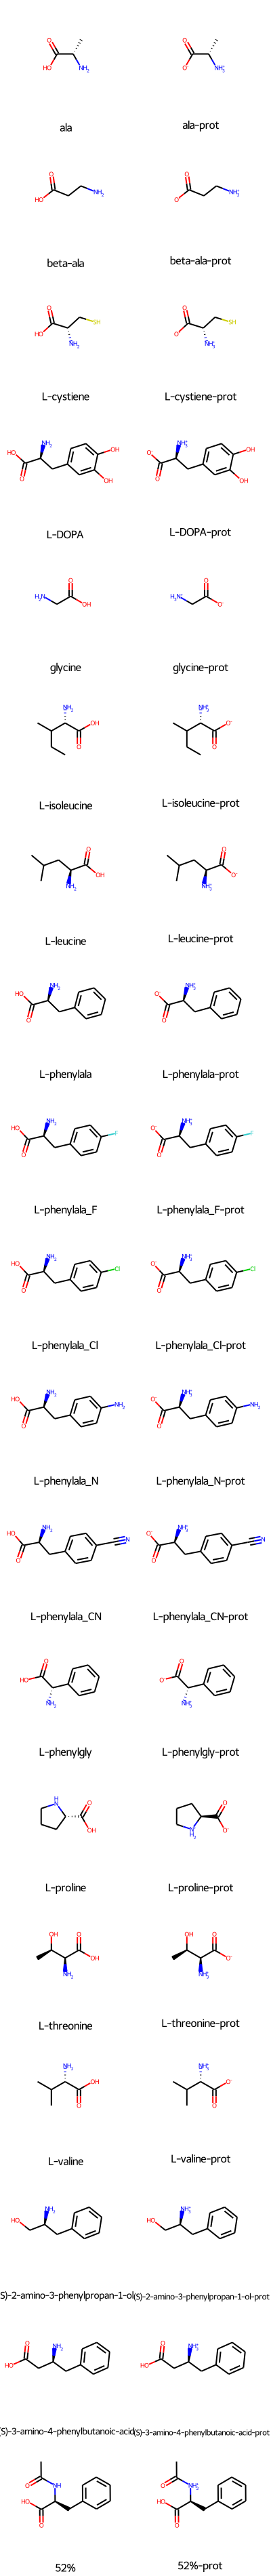

In [5]:
# Connect to the database
mDB = MongoClient("192.168.41.8", port=27017)
aaCol = mDB['aa']['aminoacids']


# Commit the amino acid table to the database
aa_fancy_dict = {}
for aa_entry in aminoacid_fancy_dict:
    aa_data = {
        'name': aa_entry[0],
        'protname': (aa_entry[0] + "-prot"),
        'shortname': aa_entry[1],
        'shortname_prot': (aa_entry[1] + "-prot"),
        'smiles': aa_entry[2],
        'smiles_prot': aa_entry[3]
    }
    # Add key to fancy dictionary
    aa_fancy_dict[aa_data['shortname']] = aa_data
    # Add shortname as _id for database purposes
    aa_data['_id'] = aa_data['shortname']
    mDB['aa']['dictionary'].update_one(
        filter={'_id': aa_data['_id']}, # update this specific entry
        update={'$set': aa_data}, # set ALL the values from the dictionary in this notebook
        upsert=True) # and create the entry if it doesn't exist

#Draw all the amino acids in the dictionary
mer_n = list(aminoacid_dict.values()) # get mer SMILES as a list
mer_names = [x for x in aminoacid_dict.keys()] # get mer names from dict keys
mol = [Chem.MolFromSmiles(mer_n) for mer_n in mer_n] # convert SMILES to molecules
Draw.MolsToGridImage(mol, molsPerRow=2, subImgSize=(200, 200), legends=mer_names) # Display molecules

In [6]:
#Section 2
#Workflow involves calculating LogP values and SASA for SMILES strings
#Let's check if H's are added before energy minimization with MMFF (or UFF)

In [7]:
# Get the ID of the best conformer given a molecule with conformers and a set of conformer IDs
# Note that mol_h MUST be pre-populated with the desired conformers
def GetBestConformerID(mol_h, ids, returnMinusOne=False, showDebug=False):
    best = []
    for id in ids:
        prop = AllChem.MMFFGetMoleculeProperties(mol_h)
        ff = AllChem.MMFFGetMoleculeForceField(mol_h, prop, confId=id)
        ff.Minimize()
        en = float(ff.CalcEnergy())
        econf = (en, id)
        best.append(econf)
    best.sort()
    if showDebug is True:
        print("Found "+str(len(best))+" conformations.")
    if len(best) == 0 and returnMinusOne is True:
        return -1
    elif len(best) == 0:
        raise Exception("Error: No valid conformations found for the molecule. Try increasing the number of conformations.")
    # The best conformer is the first tuple and the ID of that conformer is the second value in the tuple
    best_id = int(best[0][1])
    # Return the best ID
    return best_id

# Utility method to save a conformer to a file
# Accepts a molecule, conformer ID, and filename
# Note that this function has a HARDCODED PREFIX FOLDER that it saves files inside of.
def SaveConformationToFile(molecule, confId=-1, filename="scratch"):
    # Hardcoded prefix where the files are saved - change if necessary
    prefix = "molecules/"
    if confId == -1:
        raise Exception("You must provide a conformation ID to use this function.")
    # Get the conformation with the given ID
    best_conf = Chem.MolToMolBlock(molecule,confId=confId)
    # Open the file, write, then close the file.
    f = open(prefix + filename, 'w+')
    # MAKE SURE this doesn't just append to the file over and over again, which would be bad
    f.write(best_conf)
    f.close()
    print("Successfully wrote conformation to file.")
    return prefix + filename

# Given a SMILES string and other parameters, this function generates the required number of conformers and gets the LogP 
# and SASA for the best one
# Calculates logP for the OVERALL MOLECULE since I couldn't work out how to do it for a conformer
# DANGER - the output of this function is NOT 100% consistent; if you get your LogP and SASA from two different runs
# you WILL run into problems. Get ALL your values at the SAME TIME.
def GetLogPAndSASAForBestConformer(smiles, numThreads=1, numConfs=1000, randomSeed=1, filename=None, useRandomCoords=True,
                                  returnMinusOne=False, showDebug=False):
    # File prefix - change if necessary
    prefix = "molecules/",
    # First process the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    mol_h = Chem.AddHs(mol)
    # Now generate the conformations
    ids = AllChem.EmbedMultipleConfs(mol_h, numConfs=numConfs, randomSeed=randomSeed, useExpTorsionAnglePrefs=True,
                                     numThreads=numThreads)
    # Find the best one
    try:
        best_conf_id = GetBestConformerID(mol_h, ids, showDebug=showDebug)
    except Exception as e:
        if returnMinusOne is True:
            return 0, 1
        else:
            raise e
    if showDebug is True:
        print("Best conformer ID is "+str(best_conf_id)+".")
    if filename is not None and returnMinusOne is False:
        # If filename given, save conformation to that file
        SaveConformationToFile(mol_h, confId=best_conf_id, filename=filename)
    elif best_conf_id == -1 and returnMinusOne is True:
        return 0, 1
    # Now calculate LogP and SASA
    # Calculate SASA based on the best conformer
    # classifyAtoms CRASHED when I tried it with , confIdx=best_conf_id
    # but someone needs to go back and make sure it's actually OK to use it without
    # and that that won't cause problems!
    radii = rdFreeSASA.classifyAtoms(mol_h)
    sasa = rdFreeSASA.CalcSASA(mol_h, radii, confIdx=best_conf_id)
    # LogP does NOT have an option to feed in a conformer so just calculate it for the overall molecule
    logP = Descriptors.MolLogP(mol_h)
    # Now return LogP and SASA
    return logP, sasa

In [8]:
# create storage dictionary
aa_list = []
#save 3D molecule as .mol file
print("Beginning amino acid update.")
for aa_name, smiles in aminoacid_dict.items():
    aa_data = {'name': aa_name, 'smiles': smiles, '_id': aa_name}
    mol = Chem.MolFromSmiles(smiles) #convert SMILES string to molecule
    mol_h = Chem.AddHs(mol) #add hydrogens
    AllChem.EmbedMolecule(mol_h,randomSeed=0xf00d)   # optional random seed for reproducibility
    AllChem.MMFFOptimizeMolecule(mol_h) #performed MMFF
    aa_data['volume'] = Chem.AllChem.ComputeMolVolume(mol_h, confId=- 1, gridSpacing=0.2, boxMargin=2.0) # Volume
    aa_data['aLogP_H'], aa_data['sasa'] = GetLogPAndSASAForBestConformer(smiles, numConfs=100, numThreads=5, randomSeed=1)
    aa_data['LogPoverSA'] = aa_data['aLogP_H']/aa_data['sasa']
    aa_data['SA_vol'] = aa_data['sasa']/aa_data['volume']
    #aaCol.insert_one(aa_data)
    aaCol.update_one(
        filter={'_id': aa_data['_id']}, # update this specific entry
        update={'$set': aa_data}, # set ALL the values from this calculation
        upsert=True) # and create the entry if it doesn't exist
    aa_list.append(aa_data)

# Inject magic values for MGS
MGS_values = {}
print("Completed amino acid update.")


Beginning amino acid update.


Completed amino acid update.


In [9]:
# Column Names
c = ["Amino Acid", "SMILES", "Volume", "LogP", "SASA", "protonated SMILES", "protonated LogP", "protonated SA"]

# Print data table from database
a = aa_list
#a = list(aaCol.find({}, {'_id':0, 'name':1, 'volume':1, 'aLogP_noH':1, 'aLogP_H':1, 'LogPoverSA':1}))
b = pd.DataFrame(a)
b.style

,name,smiles,_id,volume,aLogP_H,sasa,LogPoverSA
0,ala,C[C@@H](C(=O)O)N,ala,85.704000,-0.581800,132.396867,-0.004394
1,ala-prot,C[C@@H](C(=O)[O-])[NH3+],ala-prot,84.752000,-2.633300,132.820469,-0.019826
2,beta-ala,NCCC(O)=O,beta-ala,85.640000,-0.580200,138.332802,-0.004194
3,beta-ala-prot,[NH3+]CCC([O-])=O,beta-ala-prot,84.840000,-2.631700,128.277701,-0.020516
4,L-cystiene,C([C@@H](C(=O)O)N)S,L-cystiene,103.688000,-0.671900,151.471888,-0.004436
5,L-cystiene-prot,C([C@@H](C(=O)[O-])[NH3+])S,L-cystiene-prot,102.936000,-2.723400,150.232365,-0.018128
6,L-DOPA,N[C@H](C(O)=O)CC1=CC=C(O)C(O)=C1,L-DOPA,174.640000,0.052200,240.727838,0.000217
7,L-DOPA-prot,[NH3+][C@H](C([O-])=O)CC1=CC=C(O)C(O)=C1,L-DOPA-prot,173.264000,-1.999300,239.777687,-0.008338
8,glycine,C(C(=O)O)N,glycine,69.440000,-0.970300,105.490848,-0.009198
9,glycine-prot,C(C(=O)[O-])[NH3+],glycine-prot,68.160000,-3.021800,105.039471,-0.028768


In [10]:
ids = AllChem.EmbedMultipleConfs(mol_h, numConfs=10, randomSeed=1, useExpTorsionAnglePrefs=True, numThreads=6)
best=[]
for id in ids:
	prop = AllChem.MMFFGetMoleculeProperties(mol_h)
	ff = AllChem.MMFFGetMoleculeForceField(mol_h, prop, confId=id)
	ff.Minimize()
	en = float(ff.CalcEnergy())
	econf = (en, id)
	best.append(econf)
best.sort()
print(best[0])
print(best)


(-41.98888431022678, 8)
[(-41.98888431022678, 8), (-41.84041860983411, 5), (-40.400570594547595, 6), (-40.40057059232624, 9), (-40.300648589002776, 7), (-39.619764867425445, 0), (-39.42925222147372, 1), (-32.68669834096055, 4), (-27.27955316566219, 2), (-25.176920771160482, 3)]


In [11]:
#Helper functions for SASA

def smiles_to_rdkit(inputSMILES):
    # create fake building block so we can use STK to convert to an RDKit molecule
	mol = Chem.MolFromSmiles(inputSMILES)
	mol_h = Chem.AddHs(mol) #add hydrogens
	AllChem.EmbedMolecule(mol_h,randomSeed=0xf00d,useRandomCoords=True)   # optional random seed for reproducibility
	AllChem.MMFFOptimizeMolecule(mol_h, maxIters=10000) #performed MMFF
	return mol_h

# convert SMILES string to RDKit molecule
#def smiles_to_rdkit(inputSMILES):
#    # create fake building block so we can use STK to convert to an RDKit molecule
#    bb_from_smiles = stk.BuildingBlock(inputSMILES)
#    rdkit_mol = bb_from_smiles.to_rdkit_mol()
#    Chem.rdmolops.SanitizeMol(rdkit_mol3)
    # add hydrogens
#    rdkit_mol_with_H = Chem.rdmolops.AddHs(rdkit_mol)
    # or not...
#    rdkit_mol_with_H = rdkit_mol
    # not sure what order addHs/sanitizing needs to run in so we will just be wasteful
#    Chem.rdmolops.SanitizeMol(rdkit_mol_with_H)
    # optimize with MMFF (or UFF)
#   Chem.AllChem.MMFFOptimizeMolecule(rdkit_mol_with_H, maxIters=20000) #default settings for maxIters is 200
#    return rdkit_mol_with_H

# calculate SASA given SMILES string
def sasa_from_smiles(inputSMILES):
    mol_h = smiles_to_rdkit(inputSMILES)
    radii = rdFreeSASA.classifyAtoms(mol_h)
    sasa = rdFreeSASA.CalcSASA(mol_h, radii)
    return sasa

In [12]:
#LogP values for n-mer

z=Chem.MolFromSmiles(Polymer1(n))
print('LogP with hydrogens is: '+ str(Descriptors.MolLogP(z, includeHs=True)))

z_no_Hs=Chem.MolFromSmiles(Polymer1(n))
print('LogP without hydrogens is: '+ str(Descriptors.MolLogP(z_no_Hs, includeHs=False)))

NameError: name 'Polymer1' is not defined